# DocAI JSON Split Address Lines

* Author: docai-incubator@google.com

## Disclaimer

This tool is not supported by the Google engineering team or product team. It is provided and supported on a best-effort basis by the DocAI Incubator Team. No guarantees of performance are implied.

## Objective

This tool is a post processing script which splits the combined address into multiple addresses. In the parsed sample json file it is observed that there exists an address field ‘shipt_to_address’ and it needs to be split into multiple ‘ship_to_address_line’ address entities . This can be achieved by splitting the address lines into multiple address elements in the json. The json Entity keys Normalized Vertices and Text Segments indexes are to be updated properly with correct values when the address line is splitted.

## Pre-requisites

* Vertex AI Notebook.
* Storage Bucket for storing input PDF files and output JSON files.
* Permission For Google Storage and Vertex AI Notebook.


## Step by Step procedure

### 1.Importing required modules

In [ ]:
# Download incubator-tools utilities module to present-working-directory
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/document-ai-samples/main/incubator-tools/best-practices/utilities/utilities.py

In [ ]:
import utilities
from io import BytesIO
from pprint import pprint
import json, copy
from pprint import pprint
from google.cloud import storage
from google.cloud import documentai_v1beta3 as documentai

### 2.Input and Output Path


Give the input and output gcs path.

* **input_path**: GCS Storage name. It should contain DocAI processed output json files. This bucket is used for processing input files and saving output files in the folders.
* **output_path**: GCS URI of the folder, where the dataset is exported from the processor.
* **Entity_names** : list of entity_names that needs to be splitted. 

In [ ]:
# INPUT : storage bucket name
input_path="gs://xxxx_xxxxxxx_xxxxxxxx/Processed/"  # path should end with '/'
# OUTPUT : storage bucket's path 
output_path="gs://xxxx_xxxxxxx_xxxxxxxx/Processed_Splitter/" # path should end with '/'

input_storage_bucket_name = input_path.split('/')[2]
input_bucket_path_prefix = '/'.join(input_path.split('/')[3:])
output_storage_bucket_name=output_path.split('/')[2]   
output_bucket_path_prefix = '/'.join(output_path.split('/')[3:])

storage_client = storage.Client()
source_bucket = storage_client.bucket(input_storage_bucket_name) # storage bucket name
source_blob = source_bucket.list_blobs(prefix=input_bucket_path_prefix) # storage bucket's sub folders path 
destination_bucket=storage_client.bucket(output_storage_bucket_name)

list_of_files = []
for blob in source_blob:
    if blob.name.endswith('.json'):
        list_of_files.append(blob.name)

* **NOTE**: The output entity will be entity_name_line for e.g. for ship_to_address the o/p will be ship_to_address_line


### 3.Run the Code

Copy the code provided in this document, Enter the paths and list of entity type names as described in previous steps. The full code is mentioned in the last section of the document.

In [ ]:
def page_anchor_fix_new(document : object) -> object :
    """
    This function takes document as input and splits the address into categories and returns document as output.
    
    Args:
         document (object): The document containing entities to be processed.

    Returns:
         document (object) : The updated document with address being splitted. 
    """
    
    token_range = {}
    for page_number, page in enumerate(document.pages):
        for token_number, token in enumerate(page.tokens):
            start_index = int(token.layout.text_anchor.text_segments[0].start_index) if token.layout.text_anchor.text_segments else 0
            end_index = int(token.layout.text_anchor.text_segments[0].end_index) if token.layout.text_anchor.text_segments else 0
            token_range[(start_index, end_index)] = {'pageNumber': page_number, 'tokenNumber': token_number}

    for entity in document.entities:
        if entity.type_ == 'ship_to_address_line':
            start = int(entity.text_anchor.text_segments[0].start_index)
            end = int(entity.text_anchor.text_segments[0].end_index) - 1
            
            lower_token, upper_token = None, None
            for (start_rng, end_rng) in token_range:
                if start >= start_rng and start < end_rng:
                    lower_token = token_range[(start_rng, end_rng)]
                if end >= start_rng and end < end_rng:
                    upper_token = token_range[(start_rng, end_rng)]

            if lower_token and upper_token:
                lower_token_data = document.pages[lower_token['pageNumber']].tokens[lower_token['tokenNumber']].layout.bounding_poly.normalized_vertices
                upper_token_data = document.pages[upper_token['pageNumber']].tokens[upper_token['tokenNumber']].layout.bounding_poly.normalized_vertices
                # print("----------------------")
                # print(lower_token_data)
                # print("***********************")
                # print(upper_token_data)
                # for A
                xA = float(lower_token_data[0].x)
                yA = float(lower_token_data[0].y)
                xA_= float(upper_token_data[0].x)
                yA_= float(upper_token_data[0].y)
                # for B
                xB = float(lower_token_data[1].x)
                yB = float(lower_token_data[1].y)
                xB_= float(upper_token_data[1].x)
                yB_= float(upper_token_data[1].y)
                # for C
                xC = float(lower_token_data[2].x)
                yC = float(lower_token_data[2].y)
                xC_= float(upper_token_data[2].x)
                yC_= float(upper_token_data[2].y)
                # for D
                xD = float(lower_token_data[3].x)
                yD = float(lower_token_data[3].y)
                xD_= float(upper_token_data[3].x)
                yD_= float(upper_token_data[3].y)
                
                A = {'x': min(xA, xA_),'y': min(yA, yA_)}
                B = {'x': max(xB, xB_),'y': min(yB, yB_)}
                C = {'x': max(xC, xC_),'y': max(yC, yC_)}
                D = {'x': min(xD, xD_),'y': max(yD, yD_)}
                entity.page_anchor.page_refs[0].bounding_poly.normalized_vertices=[A,B,C,D]
    return document


In [ ]:
for i in range(0,len(list_of_files)):
    print('\nProcessing >>> ',list_of_files[i])
    js=json.loads(source_bucket.blob(list_of_files[i]).download_as_string().decode('utf-8'))
    document1 = documentai.Document.from_json(json.dumps(js))

    addr_content = ''  
    addr_splits = []
    
    copy_enty = {}
    
    start_idx_list = []
    end_idx_list = []
    
    for entity in document1.entities:
        if entity.type_ == "ship_to_address_line":
            copy_enty = entity
            addr_content = entity.text_anchor.content
            addr_splits = addr_content.strip().split('\n')
            
            ts = entity.text_anchor.text_segments
            for start_end_idx in ts:
                start_idx_list.append(start_end_idx.start_index)
                end_idx_list.append(start_end_idx.end_index)
    
        
    start_index1=int(min(start_idx_list))
    end_index1=int(max(end_idx_list))

    try:
        for x in range(0,len(addr_splits)):
            enty = copy.deepcopy(copy_enty)
            del enty.id
            enty.mention_text = addr_splits[x]
            enty.text_anchor.content = addr_splits[x]
            enty.type_ = enty.type_ + '_line'

            s_idx = document1.text.find(addr_splits[x],start_index1,end_index1)
            e_idx = s_idx + len(addr_splits[x]) + 1
            start_index1=start_index1+len(addr_splits[x])
            # start_idx = s_idx+int(min(start_idx_list))
            # end_idx = e_idx+int(min(start_idx_list))
            # print('\n >>> start_idx , end_idx>>>> ',s_idx , e_idx)
            enty.text_anchor.text_segments = [{'end_index' : e_idx, 'start_index' : s_idx}]
            document1.entities.append(enty)

        for entity in document1.entities:
            if entity.type_ == 'ship_to_address_line':
                document1.entities.remove(entity)

        document2 = page_anchor_fix_new(document1)

        utilities.store_document_as_json(documentai.Document.to_json(document2), output_storage_bucket_name,output_bucket_path_prefix+'_'+list_of_files[i].split('/')[-1] )

        print("\nCompleted")
        
    except Exception as e:
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>"+ list_of_files[i] +" was not processed successfully!!!")
        # print(e)
        traceback_str = traceback.format_exc()
        # print(traceback_str)
        continue


### 4.Output

The post processed json field can be found in the storage path provided by the user during the script execution that is **output_bucket_path**. 

### 5.Comparison Between Input and Output File

#### Post processing results

Upon running the post processing script against input data. The resultant output json data is obtained. The following table highlights the differences for following elements in the json document.
* Address
* Normalized Vertices
* Text Segment indexes


![Screenshot 2023-11-14 12.16.29 PM.png](https://screenshot.googleplex.com/7wNxnbUWMTznRbC.png)
![Screenshot 2023-11-14 12.24.31 PM.png](https://screenshot.googleplex.com/Tv3wWG7BNXy5Utk.png)

##### When the output json document is imported into the processor, it is observed that the address is now a multiple entity and has the bounding boxes as shown:


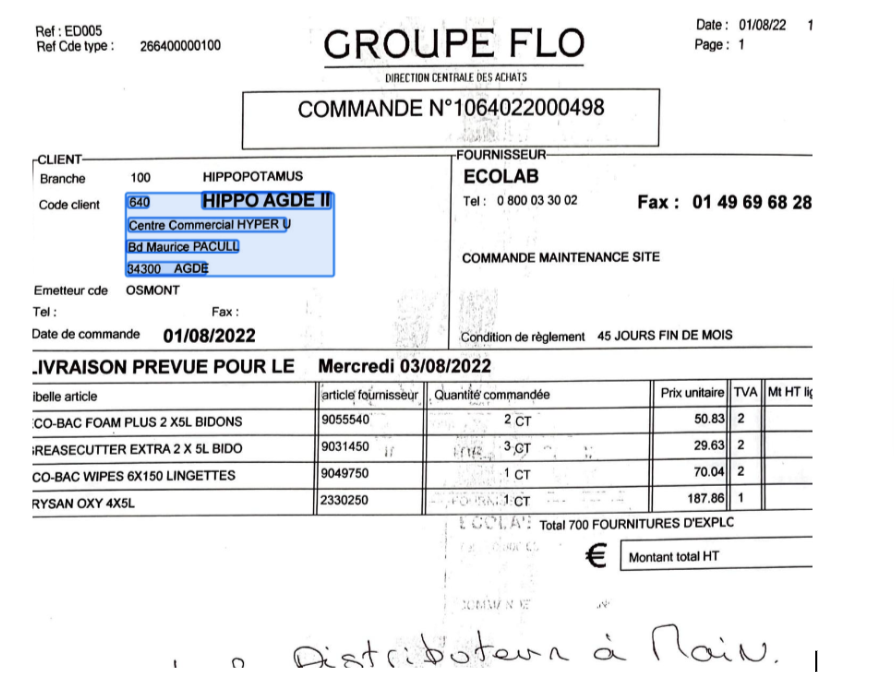